In [1]:
# libraries
import os
import sys
import json
import numpy as np
import pandas as pd
sys.path.append(os.path.abspath('../../'))
sys.path.append(os.path.abspath('../../extra_files'))
import helper as hp
from imageio import imwrite, imread
from skimage.transform import resize

In [2]:
# File paths
data_path = '/home/aldo/Documents/data-cic/'
preprocess_path = data_path + 'preprocess_data'

## Training SSD300 trained with mobilenet backbone trained

In [3]:
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TerminateOnNaN, CSVLogger, EarlyStopping, ReduceLROnPlateau
from keras import backend as K
from keras.models import load_model
from math import ceil
import numpy as np
from matplotlib import pyplot as plt

from light_models.keras_ssd300_squeezenext import ssd_300
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization

from ssd_encoder_decoder.ssd_input_encoder import SSDInputEncoder
from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_geometric_ops import Resize
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms

from extra_files.f1_callback import F1_callback as f1_call

Using TensorFlow backend.
/home/aldo/Documents/ssd/data_generator/object_detection_2d_data_generator.py:43: UserWarning: 'BeautifulSoup' module is missing. The XML-parser will be unavailable.
  warnings.warn("'BeautifulSoup' module is missing. The XML-parser will be unavailable.")


### Parameters (original SSD300 architecture)

In [5]:
## Parameteres needed for ssd_300() and SSDInputEncoder()

img_height = 300 # Height of the model input images
img_width = 300 # Width of the model input images
img_channels = 3 # Number of color channels of the model input images
mean_color = [1., 1., 1.] # The per-channel mean of the images in the dataset. Do not change this value if you're using any of the pre-trained weights.
divide_by_stddev = [127.5, 127.5, 127.5]
swap_channels = False # The color channel order in the original SSD is BGR, so we'll have the model reverse the color channel order of the input images.
n_classes = 1 # Number of positive classes, e.g. 20 for Pascal VOC, 80 for MS COCO
scales_pascal = [0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05] # The anchor box scaling factors used in the original SSD300 for the Pascal VOC datasets
scales = scales_pascal
#scales = [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05]
aspect_ratios = [[1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5]] # The anchor box aspect ratios used in the original SSD300; the order matters
two_boxes_for_ar1 = True
steps = [16, 30, 60, 100, 150, 300] # The space between two adjacent anchor box center points for each predictor layer.
offsets = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5] # The offsets of the first anchor box center points from the top and left borders of the image as a fraction of the step size for each predictor layer.
clip_boxes = False # Whether or not to clip the anchor boxes to lie entirely within the image boundaries
variances = [0.1, 0.1, 0.2, 0.2] # The variances by which the encoded target coordinates are divided as in the original implementation
normalize_coords = True

## Create new model with SSD weights

In [6]:
# 1: Build the Keras model.

K.clear_session() # Clear previous models from memory.

model = ssd_300(image_size=(img_height, img_width, img_channels),
                n_classes=n_classes,
                mode='training',
                wider=1.2,
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                clip_boxes=clip_boxes,
                variances=variances,
                normalize_coords=normalize_coords,
                subtract_mean=mean_color,
                divide_by_stddev=divide_by_stddev,
                swap_channels=swap_channels)

# 3: Instantiate an optimizer and the SSD loss function and compile the model.
#    If you want to follow the original Caffe implementation, use the preset SGD
#    optimizer, otherwise I'd recommend the commented-out Adam optimizer.

adam = Adam(lr=0.001)
#sgd = SGD(lr=0.001, momentum=0.9, decay=0.0, nesterov=False)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

In [6]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
identity_layer (Lambda)         (None, 300, 300, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
input_stddev_normalization (Lam (None, 300, 300, 3)  0           identity_layer[0][0]             
__________________________________________________________________________________________________
input_mean_normalization (Lambd (None, 300, 300, 3)  0           input_stddev_normalization[0][0] 
__________________________________________________________________________________________________
model_2 (M

## Data generator for the training

In [7]:
# 1: Instantiate two `DataGenerator` objects: One for training, one for validation.

# Optional: If you have enough memory, consider loading the images into memory for the reasons explained above.

train_dataset = DataGenerator(load_images_into_memory=True, hdf5_dataset_path=None)
val_dataset = DataGenerator(load_images_into_memory=True, hdf5_dataset_path=None)

# 2: Parse the image and label lists for the training and validation datasets.

# TODO: Set the paths to your dataset here.

# Images
images_dir = data_path + 'PASCAL'
#images_dir = data_path + 'COCO'

# Ground truth
#train_labels_filename = preprocess_path + '/PASCAL_train.csv'
train_labels_filename = preprocess_path + '/PASCAL_train_val.csv'
val_labels_filename   = preprocess_path + '/PASCAL_val.csv'

train_dataset.parse_csv(images_dir=images_dir,
                        labels_filename=train_labels_filename,
                        input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'], # This is the order of the first six columns in the CSV file that contains the labels for your dataset. If your labels are in XML format, maybe the XML parser will be helpful, check the documentation.
                        include_classes='all')

val_dataset.parse_csv(#images_dir=images_dir,
                      data_path + 'PASCAL',
                      labels_filename=val_labels_filename,
                      input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'],
                      include_classes='all')

# Get the number of samples in the training and validations datasets.
train_dataset_size = train_dataset.get_dataset_size()
val_dataset_size   = val_dataset.get_dataset_size()

print("Number of images in the training dataset:\t{:>6}".format(train_dataset_size))
print("Number of images in the validation dataset:\t{:>6}".format(val_dataset_size))

Loading images into memory: 100%|██████████| 1025/1025 [00:04<00:00, 221.19it/s]
Number of images in the training dataset:	  6469
Number of images in the validation dataset:	  1025


In [8]:
# 3: Set the batch size.
batch_size = 32 # Change the batch size if you like, or if you run into GPU memory issues.

# 4: Set the image transformations for pre-processing and data augmentation options.
# For the training generator:
ssd_data_augmentation = SSDDataAugmentation(img_height=img_height,
                                            img_width=img_width,
                                            background=mean_color)

# For the validation generator:
convert_to_3_channels = ConvertTo3Channels()
resize = Resize(height=img_height, width=img_width)

# 5: Instantiate an encoder that can encode ground truth labels into the format needed by the SSD loss function.
# The encoder constructor needs the spatial dimensions of the model's predictor layers to create the anchor boxes.
predictor_sizes = [model.get_layer('conv104_mbox_conf').output_shape[1:3],
                   model.get_layer('conv111_mbox_conf').output_shape[1:3],
                   model.get_layer('conv112_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv113_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv114_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv115_2_mbox_conf').output_shape[1:3]]

ssd_input_encoder = SSDInputEncoder(img_height=img_height,
                                    img_width=img_width,
                                    n_classes=n_classes,
                                    predictor_sizes=predictor_sizes,
                                    scales=scales,
                                    aspect_ratios_per_layer=aspect_ratios,
                                    two_boxes_for_ar1=two_boxes_for_ar1,
                                    steps=steps,
                                    offsets=offsets,
                                    clip_boxes=clip_boxes,
                                    variances=variances,
                                    matching_type='multi',
                                    pos_iou_threshold=0.5,
                                    neg_iou_limit=0.5,
                                    normalize_coords=normalize_coords)

# 6: Create the generator handles that will be passed to Keras' `fit_generator()` function.
train_generator = train_dataset.generate(batch_size=batch_size,
                                         shuffle=True,
                                         transformations=[ssd_data_augmentation],
                                         label_encoder=ssd_input_encoder,
                                         returns={'processed_images',
                                                  'encoded_labels'},
                                         keep_images_without_gt=False)

val_generator = val_dataset.generate(batch_size=batch_size,
                                     shuffle=False,
                                     transformations=[convert_to_3_channels,
                                                      resize],
                                     label_encoder=ssd_input_encoder,
                                     returns={'processed_images',
                                              'encoded_labels'},
                                     keep_images_without_gt=False)

# Get the number of samples in the training and validations datasets.
train_dataset_size = train_dataset.get_dataset_size()
val_dataset_size   = val_dataset.get_dataset_size()

print("Number of images in the training dataset:\t{:>6}".format(train_dataset_size))
print("Number of images in the validation dataset:\t{:>6}".format(val_dataset_size))

Number of images in the training dataset:	  6469
Number of images in the validation dataset:	  1025


## Remaining training parameters

In [9]:
# Define a learning rate schedule.
def lr_schedule(epoch):
    if epoch < 60:
        return 0.0001
    elif epoch < 70:
        return 0.00001
    else:
        return 0.000001

In [8]:
lr_list = [0.01, 0.001, 0.0001]

for lr in lr_list:
    # 1: Build the Keras model.
    K.clear_session() # Clear previous models from memory.

    print('TRAINING MODEL WITH LEARNING RATE:', lr)
    
    model = ssd_300(image_size=(img_height, img_width, img_channels),
                n_classes=n_classes,
                mode='training',
                scales=scales,
                wider=1.2,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                clip_boxes=clip_boxes,
                variances=variances,
                normalize_coords=normalize_coords,
                subtract_mean=mean_color,
                divide_by_stddev=divide_by_stddev,
                swap_channels=swap_channels)

    adam = Adam(lr=lr)
    ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)
    model.compile(optimizer=adam, loss=ssd_loss.compute_loss)
    
    # Define model callbacks.
    main_path = '/home/aldo/Downloads/squeezenext/'
    # TODO: Set the filepath under which you want to save the model.

    csv_logger = CSVLogger(filename=main_path + 'model_' + str(lr) + '.csv',
                           separator=',',
                           append=True)


    f1_callback = f1_call(0.20, 
                           0.45, 
                           200, 
                           normalize_coords, 
                           img_height, 
                           img_width, 
                           (1, 2268, 14),
                           main_path + 'f1_' + str(lr) + '.csv',
                           main_path + 'model.h5',
                           label_csv='/home/aldo/Documents/data-cic/preprocess_data/PASCAL_val.csv',
                           path_img='/home/aldo/Documents/data-cic/PASCAL',
                           verborse=True)


    callbacks = [csv_logger,
                 f1_callback]
    
    initial_epoch   = 0
    final_epoch     = 100
    steps_per_epoch = 200

    history = model.fit_generator(generator=train_generator,
                                  steps_per_epoch=steps_per_epoch,
                                  epochs=final_epoch,
                                  callbacks=callbacks,
                                  validation_data=val_generator,
                                  validation_steps=ceil(val_dataset_size/batch_size),
                                  initial_epoch=initial_epoch)

TRAINING MODEL WITH LEARNING RATE: 0.01
Epoch 1/100
200/200 [==============================] - 164s 818ms/step - loss: 115.7433 - val_loss: 107.5375
Number of images: 1025
Presicion: 0.0257
Recall: 0.1969
F1 score: 0.0455
F1 score: 0.045493340836044074
Improve F1 score from -inf to 0.045493340836044074
Epoch 2/100
200/200 [==============================] - 134s 672ms/step - loss: 108.1524 - val_loss: 108.2782


/home/aldo/Documents/ssd/bounding_box_utils/bounding_box_utils.py:383: RuntimeWarning: invalid value encountered in true_divide
  return intersection_areas / union_areas
/home/aldo/Documents/ssd/ssd_encoder_decoder/ssd_output_decoder.py:91: RuntimeWarning: invalid value encountered in less_equal
  boxes_left = boxes_left[similarities <= iou_threshold] # ...so that we can remove the ones that overlap too much with the maximum box


Number of images: 1025
Presicion: 0.0184
Recall: 0.2034
F1 score: 0.0337
F1 score: 0.0337292285123962
Epoch 3/100
200/200 [==============================] - 109s 547ms/step - loss: 107.1478 - val_loss: 59.4383
Number of images: 1025
Presicion: 0.0256
Recall: 0.3481
F1 score: 0.0477
F1 score: 0.04771331316417586
Improve F1 score from 0.045493340836044074 to 0.04771331316417586
Epoch 4/100
200/200 [==============================] - 110s 550ms/step - loss: 106.9689 - val_loss: 106.6002
Number of images: 1025
Presicion: 0.0441
Recall: 0.3866
F1 score: 0.0792
F1 score: 0.07915841350082345
Improve F1 score from 0.04771331316417586 to 0.07915841350082345
Epoch 5/100
200/200 [==============================] - 111s 555ms/step - loss: 31.0705 - val_loss: 1592.7230


/home/aldo/Documents/ssd/ssd_encoder_decoder/ssd_output_decoder.py:175: RuntimeWarning: overflow encountered in exp
  y_pred_decoded_raw[:,:,[-2,-1]] = np.exp(y_pred_decoded_raw[:,:,[-2,-1]] * y_pred[:,:,[-2,-1]]) # exp(ln(w(pred)/w(anchor)) / w_variance * w_variance) == w(pred) / w(anchor), exp(ln(h(pred)/h(anchor)) / h_variance * h_variance) == h(pred) / h(anchor)


Number of images: 1025
Presicion: 0.0759
Recall: 0.3872
F1 score: 0.1269
F1 score: 0.12693525570590633
Improve F1 score from 0.07915841350082345 to 0.12693525570590633
Epoch 6/100
200/200 [==============================] - 108s 541ms/step - loss: 12.9396 - val_loss: 6150809110861.6738


/home/aldo/Documents/ssd/bounding_box_utils/bounding_box_utils.py:280: RuntimeWarning: invalid value encountered in multiply
  return side_lengths[:,0] * side_lengths[:,1]
/home/aldo/Documents/ssd/bounding_box_utils/bounding_box_utils.py:378: RuntimeWarning: invalid value encountered in multiply
  boxes1_areas = (boxes1[:,xmax] - boxes1[:,xmin] + d) * (boxes1[:,ymax] - boxes1[:,ymin] + d)
/home/aldo/Documents/ssd/bounding_box_utils/bounding_box_utils.py:379: RuntimeWarning: invalid value encountered in multiply
  boxes2_areas = (boxes2[:,xmax] - boxes2[:,xmin] + d) * (boxes2[:,ymax] - boxes2[:,ymin] + d)
/home/aldo/Documents/ssd/bounding_box_utils/bounding_box_utils.py:381: RuntimeWarning: invalid value encountered in subtract
  union_areas = boxes1_areas + boxes2_areas - intersection_areas
/home/aldo/Documents/ssd/extra_files/helper.py:229: RuntimeWarning: invalid value encountered in double_scalars
  xB = min(boxA[2] + boxA[0], boxB[2] + boxB[0])
/home/aldo/Documents/ssd/extra_files/

Number of images: 1025
Presicion: 0.0
Recall: 0.0
F1 score: 0.0
F1 score: 0.0
Epoch 7/100
200/200 [==============================] - 108s 540ms/step - loss: 8.0514 - val_loss: 7.3643
Number of images: 1025
Presicion: 0.0728
Recall: 0.4081
F1 score: 0.1236
F1 score: 0.12362434215445253
Epoch 8/100
200/200 [==============================] - 108s 540ms/step - loss: 7.0711 - val_loss: 191.5118


/home/aldo/Documents/ssd/ssd_encoder_decoder/ssd_output_decoder.py:197: RuntimeWarning: overflow encountered in multiply
  y_pred_decoded_raw[:,:,[-4,-2]] *= img_width # Convert xmin, xmax back to absolute coordinates
/home/aldo/Documents/ssd/ssd_encoder_decoder/ssd_output_decoder.py:198: RuntimeWarning: overflow encountered in multiply
  y_pred_decoded_raw[:,:,[-3,-1]] *= img_height # Convert ymin, ymax back to absolute coordinates


Number of images: 1025
Presicion: 0.0772
Recall: 0.3765
F1 score: 0.1281
F1 score: 0.12809728044233396
Improve F1 score from 0.12693525570590633 to 0.12809728044233396
Epoch 9/100
200/200 [==============================] - 108s 542ms/step - loss: 5.6192 - val_loss: 5.3372
Number of images: 1025
Presicion: 0.0581
Recall: 0.4295
F1 score: 0.1023
F1 score: 0.10229396096575288
Epoch 10/100
200/200 [==============================] - 113s 563ms/step - loss: 5.5188 - val_loss: 5.1661
Number of images: 1025
Presicion: 0.0773
Recall: 0.4085
F1 score: 0.1299
F1 score: 0.12993809334648074
Improve F1 score from 0.12809728044233396 to 0.12993809334648074
Epoch 11/100
200/200 [==============================] - 109s 546ms/step - loss: 5.5640 - val_loss: 12.7212
Number of images: 1025
Presicion: 0.0841
Recall: 0.4145
F1 score: 0.1399
F1 score: 0.13987563007936019
Improve F1 score from 0.12993809334648074 to 0.13987563007936019
Epoch 12/100
200/200 [==============================] - 107s 537ms/step - l

/home/aldo/Documents/ssd/bounding_box_utils/bounding_box_utils.py:378: RuntimeWarning: overflow encountered in subtract
  boxes1_areas = (boxes1[:,xmax] - boxes1[:,xmin] + d) * (boxes1[:,ymax] - boxes1[:,ymin] + d)
/home/aldo/Documents/ssd/bounding_box_utils/bounding_box_utils.py:379: RuntimeWarning: overflow encountered in subtract
  boxes2_areas = (boxes2[:,xmax] - boxes2[:,xmin] + d) * (boxes2[:,ymax] - boxes2[:,ymin] + d)
/home/aldo/Documents/ssd/bounding_box_utils/bounding_box_utils.py:378: RuntimeWarning: overflow encountered in multiply
  boxes1_areas = (boxes1[:,xmax] - boxes1[:,xmin] + d) * (boxes1[:,ymax] - boxes1[:,ymin] + d)
/home/aldo/Documents/ssd/bounding_box_utils/bounding_box_utils.py:379: RuntimeWarning: overflow encountered in multiply
  boxes2_areas = (boxes2[:,xmax] - boxes2[:,xmin] + d) * (boxes2[:,ymax] - boxes2[:,ymin] + d)
/home/aldo/Documents/ssd/extra_files/helper.py:213: RuntimeWarning: overflow encountered in double_scalars
  b = [box[0], box[1], box[2], bo

Number of images: 1025
Presicion: 0.0641
Recall: 0.0564
F1 score: 0.06
F1 score: 0.059976881568140517
Epoch 13/100
200/200 [==============================] - 109s 546ms/step - loss: 11.0507 - val_loss: 532.6650
Number of images: 1025
Presicion: 0.1577
Recall: 0.2004
F1 score: 0.1765
F1 score: 0.17651224991237002
Improve F1 score from 0.13987563007936019 to 0.17651224991237002
Epoch 14/100
200/200 [==============================] - 108s 542ms/step - loss: 6.1399 - val_loss: 5.3678
Number of images: 1025
Presicion: 0.072
Recall: 0.425
F1 score: 0.1232
F1 score: 0.12316826519885475
Epoch 15/100
200/200 [==============================] - 111s 554ms/step - loss: 5.5820 - val_loss: 6.8965
Number of images: 1025
Presicion: 0.071
Recall: 0.4348
F1 score: 0.1221
F1 score: 0.1221231469232503
Epoch 16/100
200/200 [==============================] - 109s 544ms/step - loss: 5.8101 - val_loss: 5.3563
Number of images: 1025
Presicion: 0.0757
Recall: 0.42
F1 score: 0.1283
F1 score: 0.1283077615900835
E

200/200 [==============================] - 112s 558ms/step - loss: 5.3809 - val_loss: 5.3254
Number of images: 1025
Presicion: 0.0784
Recall: 0.4282
F1 score: 0.1325
F1 score: 0.13253093011780565
Epoch 52/100
200/200 [==============================] - 108s 541ms/step - loss: 5.3015 - val_loss: 5.1069
Number of images: 1025
Presicion: 0.0639
Recall: 0.4264
F1 score: 0.1112
F1 score: 0.11115900395539344
Epoch 53/100
200/200 [==============================] - 111s 553ms/step - loss: 5.2947 - val_loss: 5.4083
Number of images: 1025
Presicion: 0.0776
Recall: 0.4256
F1 score: 0.1312
F1 score: 0.13122550977446223
Epoch 54/100
200/200 [==============================] - 111s 554ms/step - loss: 5.4807 - val_loss: 6.4498
Number of images: 1025
Presicion: 0.0817
Recall: 0.4121
F1 score: 0.1364
F1 score: 0.13637657596429026
Epoch 55/100
200/200 [==============================] - 108s 539ms/step - loss: 5.3260 - val_loss: 5.0929
Number of images: 1025
Presicion: 0.0496
Recall: 0.4115
F1 score: 0.088

/home/aldo/Documents/ssd/bounding_box_utils/bounding_box_utils.py:280: RuntimeWarning: overflow encountered in multiply
  return side_lengths[:,0] * side_lengths[:,1]


Number of images: 1025
Presicion: 0.0703
Recall: 0.4049
F1 score: 0.1198
F1 score: 0.11980724813353359
Epoch 90/100
200/200 [==============================] - 108s 538ms/step - loss: 6.7246 - val_loss: 77.0385
Number of images: 1025
Presicion: 0.0428
Recall: 0.3247
F1 score: 0.0756
F1 score: 0.07558662498736195
Epoch 91/100
200/200 [==============================] - 108s 539ms/step - loss: 5.8515 - val_loss: 18.3799
Number of images: 1025
Presicion: 0.0331
Recall: 0.3747
F1 score: 0.0609
F1 score: 0.060881115259903064
Epoch 92/100
200/200 [==============================] - 107s 534ms/step - loss: 5.6014 - val_loss: 5.1951
Number of images: 1025
Presicion: 0.0603
Recall: 0.4304
F1 score: 0.1058
F1 score: 0.10575289697485075
Epoch 93/100
200/200 [==============================] - 111s 556ms/step - loss: 5.3354 - val_loss: 5.1193
Number of images: 1025
Presicion: 0.0151
Recall: 0.2693
F1 score: 0.0285
F1 score: 0.028520262764161208
Epoch 94/100
200/200 [==============================] - 1

200/200 [==============================] - 110s 549ms/step - loss: 5.7961 - val_loss: 7.7352
Number of images: 1025
Presicion: 0.0317
Recall: 0.3669
F1 score: 0.0583
F1 score: 0.05827805861908598
Epoch 28/100
200/200 [==============================] - 111s 554ms/step - loss: 5.4999 - val_loss: 5.0233
Number of images: 1025
Presicion: 0.0701
Recall: 0.4711
F1 score: 0.1221
F1 score: 0.12210127435795476
Epoch 29/100
200/200 [==============================] - 110s 552ms/step - loss: 5.3087 - val_loss: 4.9247
Number of images: 1025
Presicion: 0.0507
Recall: 0.4686
F1 score: 0.0915
F1 score: 0.09145348221002389
Epoch 30/100
200/200 [==============================] - 110s 552ms/step - loss: 5.2261 - val_loss: 4.9927
Number of images: 1025
Presicion: 0.0619
Recall: 0.4778
F1 score: 0.1096
F1 score: 0.10961062002404547
Epoch 31/100
200/200 [==============================] - 110s 551ms/step - loss: 5.3552 - val_loss: 8.2821
Number of images: 1025
Presicion: 0.0412
Recall: 0.4206
F1 score: 0.075

200/200 [==============================] - 111s 553ms/step - loss: 4.7613 - val_loss: 4.6641
Number of images: 1025
Presicion: 0.0534
Recall: 0.506
F1 score: 0.0967
F1 score: 0.09667160334922222
Epoch 67/100
200/200 [==============================] - 111s 556ms/step - loss: 4.6804 - val_loss: 4.7099
Number of images: 1025
Presicion: 0.0543
Recall: 0.5139
F1 score: 0.0982
F1 score: 0.0982339998863827
Epoch 68/100
200/200 [==============================] - 110s 549ms/step - loss: 4.6153 - val_loss: 4.6062
Number of images: 1025
Presicion: 0.0521
Recall: 0.5044
F1 score: 0.0944
F1 score: 0.09439847347144473
Epoch 69/100
200/200 [==============================] - 112s 561ms/step - loss: 4.7104 - val_loss: 4.5636
Number of images: 1025
Presicion: 0.062
Recall: 0.5019
F1 score: 0.1103
F1 score: 0.11029386520201749
Epoch 70/100
200/200 [==============================] - 111s 553ms/step - loss: 4.5557 - val_loss: 4.7786
Number of images: 1025
Presicion: 0.065
Recall: 0.5069
F1 score: 0.1152
F1

200/200 [==============================] - 110s 552ms/step - loss: 8.6983 - val_loss: 7.2814
Number of images: 1025
Presicion: 0.1168
Recall: 0.3719
F1 score: 0.1778
F1 score: 0.17778298072931037
Improve F1 score from 0.17131176354971042 to 0.17778298072931037
Epoch 5/100
200/200 [==============================] - 110s 550ms/step - loss: 8.0687 - val_loss: 6.8757
Number of images: 1025
Presicion: 0.1125
Recall: 0.3746
F1 score: 0.1731
F1 score: 0.17307699783014974
Epoch 6/100
200/200 [==============================] - 111s 556ms/step - loss: 7.5500 - val_loss: 6.5909
Number of images: 1025
Presicion: 0.1051
Recall: 0.3968
F1 score: 0.1662
F1 score: 0.16623988349228744
Epoch 7/100
200/200 [==============================] - 112s 561ms/step - loss: 7.3534 - val_loss: 6.3486
Number of images: 1025
Presicion: 0.102
Recall: 0.3898
F1 score: 0.1617
F1 score: 0.16170587986185853
Epoch 8/100
200/200 [==============================] - 111s 553ms/step - loss: 6.8594 - val_loss: 6.2053
Number of i

200/200 [==============================] - 111s 557ms/step - loss: 4.7852 - val_loss: 4.7398
Number of images: 1025
Presicion: 0.0805
Recall: 0.4801
F1 score: 0.1379
F1 score: 0.1378740430752569
Epoch 44/100
200/200 [==============================] - 110s 550ms/step - loss: 4.7617 - val_loss: 4.7082
Number of images: 1025
Presicion: 0.0685
Recall: 0.4947
F1 score: 0.1203
F1 score: 0.12027337365658256
Epoch 45/100
200/200 [==============================] - 111s 554ms/step - loss: 4.7291 - val_loss: 4.7107
Number of images: 1025
Presicion: 0.0821
Recall: 0.4777
F1 score: 0.1402
F1 score: 0.14016444485630214
Epoch 46/100
200/200 [==============================] - 111s 554ms/step - loss: 4.7327 - val_loss: 4.6827
Number of images: 1025
Presicion: 0.0739
Recall: 0.4878
F1 score: 0.1284
F1 score: 0.1283835166866097
Epoch 47/100
200/200 [==============================] - 111s 557ms/step - loss: 4.7034 - val_loss: 4.7115
Number of images: 1025
Presicion: 0.0696
Recall: 0.4913
F1 score: 0.122
F

200/200 [==============================] - 111s 555ms/step - loss: 4.3972 - val_loss: 4.3606
Number of images: 1025
Presicion: 0.0649
Recall: 0.537
F1 score: 0.1158
F1 score: 0.11575709803406298
Epoch 83/100
200/200 [==============================] - 110s 552ms/step - loss: 4.4004 - val_loss: 4.3894
Number of images: 1025
Presicion: 0.0724
Recall: 0.5199
F1 score: 0.1271
F1 score: 0.12706956615555554
Epoch 84/100
200/200 [==============================] - 110s 549ms/step - loss: 4.3756 - val_loss: 4.3715
Number of images: 1025
Presicion: 0.0687
Recall: 0.5393
F1 score: 0.1219
F1 score: 0.12190334293865211
Epoch 85/100
200/200 [==============================] - 111s 553ms/step - loss: 4.3509 - val_loss: 4.3576
Number of images: 1025
Presicion: 0.0658
Recall: 0.5318
F1 score: 0.1171
F1 score: 0.11709469818509971
Epoch 86/100
200/200 [==============================] - 111s 556ms/step - loss: 4.2863 - val_loss: 4.3934
Number of images: 1025
Presicion: 0.0685
Recall: 0.5323
F1 score: 0.1213

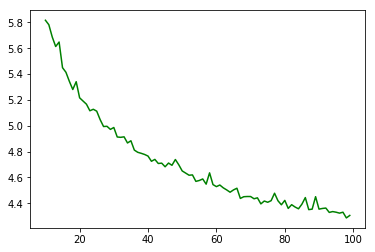

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
mob_01 = pd.read_csv(main_path + 'model_0.01.csv')
mob_001 = pd.read_csv(main_path + 'model_0.001.csv')
mob_0001 = pd.read_csv(main_path + 'model_0.0001.csv')

fig, ax = plt.subplots()
#ax.plot(mob_01['epoch'][10:], mob_01['val_loss'][10:], color='r')
#ax.plot(mob_001['epoch'][10:], mob_001['val_loss'][10:], color='b')
ax.plot(mob_0001['epoch'][10:], mob_0001['val_loss'][10:], color='g')

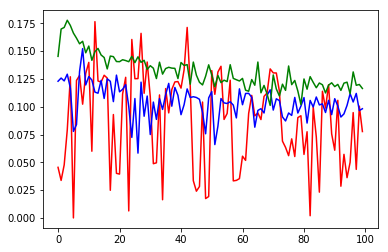

In [10]:
mob_01_f1 = pd.read_csv(main_path + 'f1_0.01.csv')
mob_001_f1 = pd.read_csv(main_path + 'f1_0.001.csv')
mob_0001_f1 = pd.read_csv(main_path + 'f1_0.0001.csv')

fig, ax = plt.subplots()
ax.plot(mob_01_f1['epoch'], mob_01_f1['f1 score'], color='r')
ax.plot(mob_001_f1['epoch'], mob_001_f1['f1 score'], color='b')
ax.plot(mob_0001_f1['epoch'], mob_0001_f1['f1 score'], color='g')

In [10]:
widers = [1.2, 0.75]

for wider in widers:
    # 1: Build the Keras model.
    K.clear_session() # Clear previous models from memory.

    print('TRAINING MODEL WITH WIDER:', wider)
    
    model = ssd_300(image_size=(img_height, img_width, img_channels),
                n_classes=n_classes,
                mode='training',
                wider=wider,
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                clip_boxes=clip_boxes,
                variances=variances,
                normalize_coords=normalize_coords,
                subtract_mean=mean_color,
                divide_by_stddev=divide_by_stddev,
                swap_channels=swap_channels)

    adam = Adam(lr=0.001)
    ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)
    model.compile(optimizer=adam, loss=ssd_loss.compute_loss)
    
    # Define model callbacks.
    main_path = '/home/aldo/Documents/'
    # TODO: Set the filepath under which you want to save the model.

    csv_logger = CSVLogger(filename=main_path + 'data-cic/history/light_models/PASCAL/squeezenext_wider_' + str(wider) + '.csv',
                           separator=',',
                           append=True)

    learning_rate_scheduler = LearningRateScheduler(schedule=lr_schedule, verbose=1)


    callbacks = [csv_logger,
                 learning_rate_scheduler]
    
    initial_epoch   = 0
    final_epoch     = 80
    steps_per_epoch = 1000

    history = model.fit_generator(generator=train_generator,
                                  steps_per_epoch=steps_per_epoch,
                                  epochs=final_epoch,
                                  callbacks=callbacks,
                                  initial_epoch=initial_epoch)
    
    model.save(main_path + 'weights/light_models/PASCAL/squeezenext_wider_' + str(wider) + '.h5')

TRAINING MODEL WITH WIDER: 1.2
Epoch 1/80

Epoch 00001: LearningRateScheduler setting learning rate to 0.0001.
1000/1000 [==============================] - 641s 641ms/step - loss: 10.3934
Epoch 2/80

Epoch 00002: LearningRateScheduler setting learning rate to 0.0001.
1000/1000 [==============================] - 567s 567ms/step - loss: 7.4114
Epoch 3/80

Epoch 00003: LearningRateScheduler setting learning rate to 0.0001.
1000/1000 [==============================] - 564s 564ms/step - loss: 6.1772
Epoch 4/80

Epoch 00004: LearningRateScheduler setting learning rate to 0.0001.
1000/1000 [==============================] - 563s 563ms/step - loss: 5.6167
Epoch 5/80

Epoch 00005: LearningRateScheduler setting learning rate to 0.0001.
1000/1000 [==============================] - 567s 567ms/step - loss: 5.3886
Epoch 6/80

Epoch 00006: LearningRateScheduler setting learning rate to 0.0001.
1000/1000 [==============================] - 565s 565ms/step - loss: 5.1285
Epoch 7/80

Epoch 00007: Learnin

1000/1000 [==============================] - 562s 562ms/step - loss: 3.9561
Epoch 54/80

Epoch 00054: LearningRateScheduler setting learning rate to 0.0001.
1000/1000 [==============================] - 560s 560ms/step - loss: 3.9442
Epoch 55/80

Epoch 00055: LearningRateScheduler setting learning rate to 0.0001.
1000/1000 [==============================] - 560s 560ms/step - loss: 3.9244
Epoch 56/80

Epoch 00056: LearningRateScheduler setting learning rate to 0.0001.
1000/1000 [==============================] - 563s 563ms/step - loss: 3.9314
Epoch 57/80

Epoch 00057: LearningRateScheduler setting learning rate to 0.0001.
1000/1000 [==============================] - 564s 564ms/step - loss: 3.9267
Epoch 58/80

Epoch 00058: LearningRateScheduler setting learning rate to 0.0001.
1000/1000 [==============================] - 563s 563ms/step - loss: 3.9139
Epoch 59/80

Epoch 00059: LearningRateScheduler setting learning rate to 0.0001.
1000/1000 [==============================] - 565s 565ms/st

1000/1000 [==============================] - 561s 561ms/step - loss: 4.3515
Epoch 26/80

Epoch 00026: LearningRateScheduler setting learning rate to 0.0001.
1000/1000 [==============================] - 558s 558ms/step - loss: 4.3168
Epoch 27/80

Epoch 00027: LearningRateScheduler setting learning rate to 0.0001.
1000/1000 [==============================] - 557s 557ms/step - loss: 4.3323
Epoch 28/80

Epoch 00028: LearningRateScheduler setting learning rate to 0.0001.
1000/1000 [==============================] - 557s 557ms/step - loss: 4.3244
Epoch 29/80

Epoch 00029: LearningRateScheduler setting learning rate to 0.0001.
1000/1000 [==============================] - 559s 559ms/step - loss: 4.2741
Epoch 30/80

Epoch 00030: LearningRateScheduler setting learning rate to 0.0001.
1000/1000 [==============================] - 558s 558ms/step - loss: 4.2758
Epoch 31/80

Epoch 00031: LearningRateScheduler setting learning rate to 0.0001.
1000/1000 [==============================] - 561s 561ms/st

1000/1000 [==============================] - 560s 560ms/step - loss: 3.8468
Epoch 78/80

Epoch 00078: LearningRateScheduler setting learning rate to 1e-06.
1000/1000 [==============================] - 560s 560ms/step - loss: 3.8522
Epoch 79/80

Epoch 00079: LearningRateScheduler setting learning rate to 1e-06.
1000/1000 [==============================] - 559s 559ms/step - loss: 3.8473
Epoch 80/80

Epoch 00080: LearningRateScheduler setting learning rate to 1e-06.
1000/1000 [==============================] - 567s 567ms/step - loss: 3.8498
